Optical field calculation using the Fourier Modal Method
====

# Part 1. Eigenmode calculation

In [10]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg, integrate

In [11]:
N=25                                    # summation limits
M=2*N+1                                 # Total Number of plane wave terms included in expansion
spatialresolution = 250

GratePeriod = 0.400      # µm
f = 0.32
l = 0.633           # µm
thetaDeg = 0
theta = thetaDeg * ((2*np.pi)/360)
eps1 = 1
sqrteps2 = 1.5
eps2=sqrteps2**2

n1=np.sqrt(eps1)
n2=np.sqrt(eps2)

k0 = 2*np.pi/l
k1=k0*np.sqrt(eps1)
kx = k1*np.sin(theta)

# constants
a = GratePeriod * f
G = 2*np.pi/GratePeriod
GrateSpacing = GratePeriod - a

ztop12 = GratePeriod/2                  # top of computational domain
zbot12 = -GratePeriod/2                 # bottom of computational domain

# build A matrix
A = np.eye(M)
for i in range(M):
        A[i ,i] = ((-N+i)*G+kx)**2


In [29]:
def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad(real_func, a, b, limit=100, **kwargs)
    imag_integral = integrate.quad(imag_func, a, b, limit=100, **kwargs)
    return real_integral[0] + 1j*imag_integral[0]

B = np.zeros((M, M), dtype=np.complex_)
for i in range(M):
    for j in range(M):
        func = lambda x: (eps1*np.heaviside(x-f*Lambda, 0)+eps2*np.heaviside(f*Lambda-x, 0)) * np.exp(-1j*(i-j)*G*x)
        B[i,j] = (1/Lambda) * complex_quadrature(func, 0, Lambda)


In [31]:
EigPb = -A + (k0**2)*B

eigvals, eigvecs = linalg.eig(A, B)

In [44]:
idx = eigvals.argsort()[::-1]   
eigenValues = eigvals[idx]
eigenVectors = eigvecs[:,idx]

eigenValues

array([ 1.44020255e+05-3.82304090e-12j,  1.43816276e+05-4.19216931e-12j,
        1.28145725e+05-1.09837156e-11j,  1.28027714e+05+6.22239264e-13j,
        1.13951428e+05+3.67522486e-11j,  1.13305963e+05+4.93561252e-11j,
        1.00756830e+05+2.44517893e-11j,  9.98140637e+04+2.58972232e-11j,
        8.83575806e+04-8.68322573e-12j,  8.78028639e+04-8.74478879e-12j,
        7.74348539e+04+4.66514981e-12j,  7.68782365e+04+4.95895598e-12j,
        6.80900696e+04-8.85518255e-13j,  6.70221619e+04+4.29502333e-12j,
        5.99795363e+04-4.40442497e-12j,  5.94486800e+04+1.88435162e-12j,
        5.31659357e+04-3.27143691e-12j,  5.31569255e+04+5.70506161e-12j,
        4.72547394e+04-2.29205003e-11j,  4.68103015e+04-9.83127717e-12j,
        4.16329519e+04+7.11520896e-14j,  4.09748558e+04+7.64293059e-12j,
        3.63046826e+04-1.32584048e-12j,  3.56561455e+04+3.99332206e-12j,
        3.12330854e+04+3.90941441e-12j,  3.07940721e+04+1.75737682e-12j,
        2.64918280e+04+4.86915559e-12j,  2.63509416

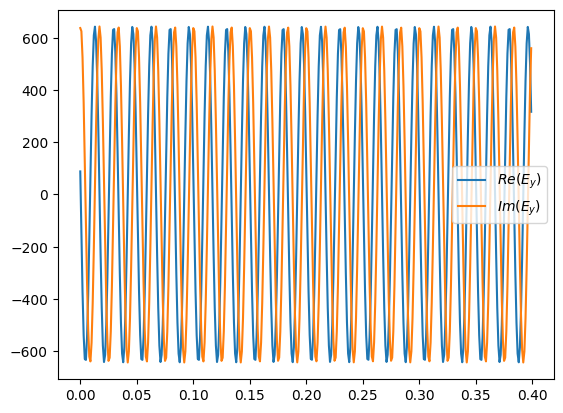

In [42]:
# normalization
for i in range(M):
    C = np.sqrt(eigvals[i]) * np.sum(np.abs(eigvecs[i])**2)*Lambda
    eigvecs[i] = -eigvecs[i]*1/np.sqrt(C)

x = np.arange(0, Lambda, 0.001)    # µm

E2x = np.zeros((len(x),M), dtype=np.complex_)

for m in range(M):
    for o in range(len(x)):
        for n in range(-N, N):
            E2x[o, m] = E2x[o, m] + eigvecs[n+N+1, m] * np.exp(1j*(kx+n*G)*x[o])

plt.figure()
plt.plot(x, np.real(E2x[:, 1]), label="$Re(E_y)$")
plt.plot(x, np.imag(E2x[:, 1]), label="$Im(E_y)$")
plt.legend()
plt.show()